# Panoramic Stitching

Kevin Walchko, created 10 Dec 2016

--------

**there is an error in OpenCV python i am waiting on being fixed**

[error](https://github.com/opencv/opencv/pull/7787)

## Mars Rover

The Curiosity rover is well known for generating panoramic views of its surroundings by stitching images together. 

![](mars/mars-rover.gif)

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import cv2
from math import sqrt
import opencvutils as cvu

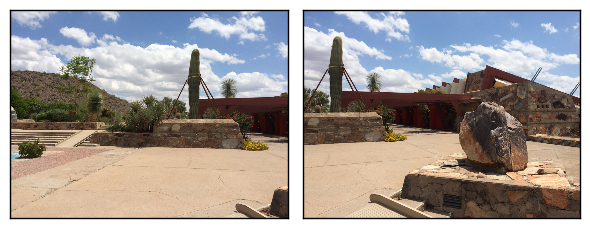

In [29]:
images = [
    'scottsdale/scottsdale_left_01.png',
    'scottsdale/scottsdale_right_01.png'
]
imgs = []
for fname in images:
    image = cv2.imread(fname)
    imgs.append(image)

plt.figure(figsize=(5,5))
cvu.imshow(imgs);

In [52]:
class Stitcher:
    def __init__(self):
        pass

    def stitch(self, images, ratio=0.75, reprojThresh=4.0):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB,
            featuresA, featuresB, ratio, reprojThresh)

        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None

        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H,
            (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect and extract features from the image
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

In [28]:
# gray = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2GRAY)
# mask = np.zeros((750,1000), np.uint8)
# mask = np.zeros((70,10), np.uint8)
# descriptor = cv2.ORB_create()
# kps, features = descriptor.detectAndCompute(gray,None)

In [54]:
help(cvu.imshow)

Help on function imshow in module opencvutils.convenience:

imshow(images, bgr=True, width=4, titles=None, figsize=None, showaxes=False)
    Make an array of plots.
    
    exmaple:
            imshow([im1,im2], bgr=True, width=1, titles=['one', 'two'], figsize=(4,2), showaxes=True)
    
    params:
            images - array of images
            bgr - if a color image, assume it is opencv and switch it rgb format
            width - how many images wide
            figsize - a tuple (width,height) of how wide the figure should be in inches (this is depended on your dpi setting)
            titles - an array of titles for each subplot
            showaxes - True/False to show axes



In [14]:
def autocrop(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = img[y:y+h,x:x+w]
    return crop

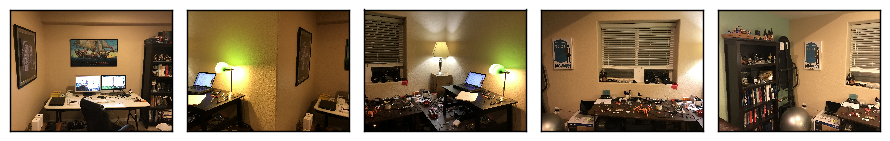

In [67]:
fname = [
    'stitch_pics/IMG_1508.JPG',
    'stitch_pics/IMG_1509.JPG',
    'stitch_pics/IMG_1510.JPG',
    'stitch_pics/IMG_1511.JPG',
    'stitch_pics/IMG_1512.JPG'
]
imgs2 = []
for f in fname:
    image = cv2.imread(f)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    imgs2.append(image)

# plt.imshow(imgs[0], cmap=plt.cm.gray);
cvu.imshow(imgs2, width=5, bgr=False, figsize=(9,9))

In [68]:
w,h,c=ans.shape
print(w,h,c)

480 640 3


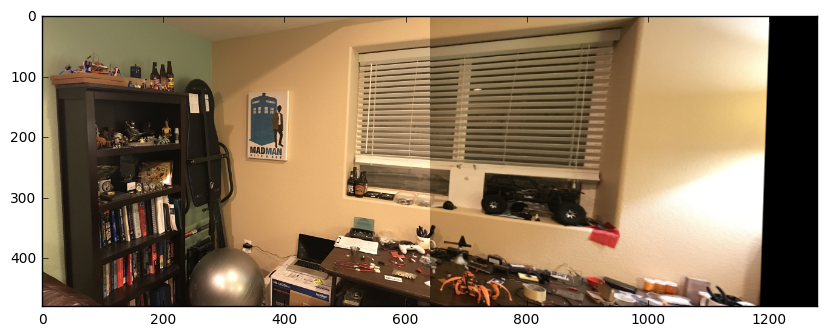

In [69]:
stitcher = Stitcher()
a = cvu.resize(imgs2[4], width=640)
b = cvu.resize(imgs2[3], width=640)
ans = stitcher.stitch([a,b], reprojThresh=1.0, ratio=0.75)
plt.figure(figsize=(10,10))
plt.imshow(ans);

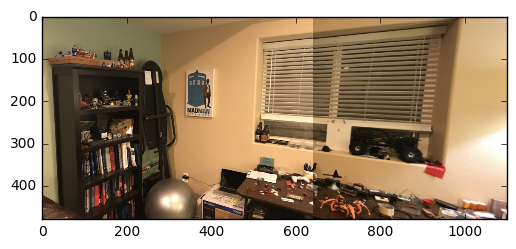

In [70]:
# trim off black right edge
nn=ans[:,0:1100]
plt.imshow(nn);

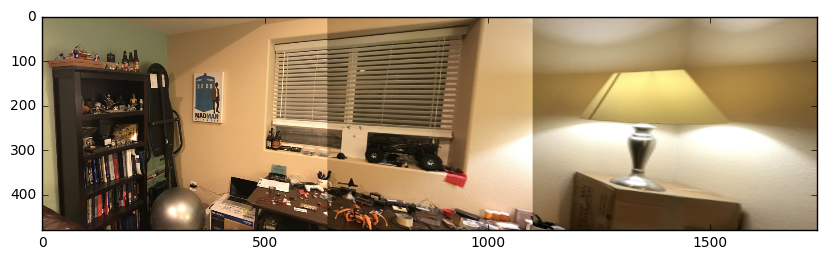

In [71]:
stitcher = Stitcher()
b = cvu.resize(imgs2[2], width=640)
ans2 = stitcher.stitch([ans[:,0:1100],b])
plt.figure(figsize=(10,10))
plt.imshow(ans2);

In [73]:
# b = cvu.resize(imgs2[1], width=640)
# ans3 = stitcher.stitch([ans2,b])
# cvu.imshow([ans3])

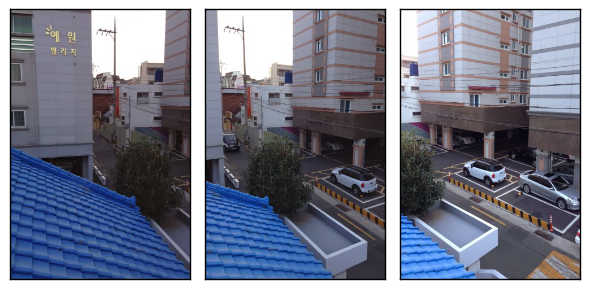

In [74]:
fname = [
    'stitching_img/S1.jpg',
    'stitching_img/S2.jpg',
    'stitching_img/S3.jpg'
]
imgs = []
for f in fname:
    image = cv2.imread(f)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    imgs.append(image)

# plt.imshow(imgs[0], cmap=plt.cm.gray);
cvu.imshow(imgs, width=3, bgr=False)

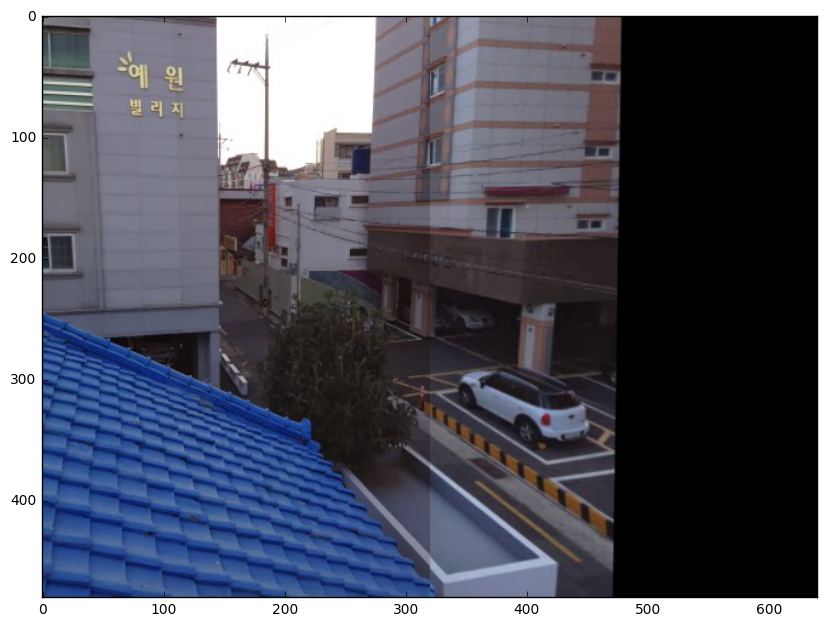

In [75]:
stitcher = Stitcher()
# a = cvu.resize(imgs[4], width=640)
# b = cvu.resize(imgs[3], width=640)
a=imgs[0]
b=imgs[1]
ans = stitcher.stitch([a,b], reprojThresh=1.0, ratio=0.75)
plt.figure(figsize=(10,10))
plt.imshow(ans);

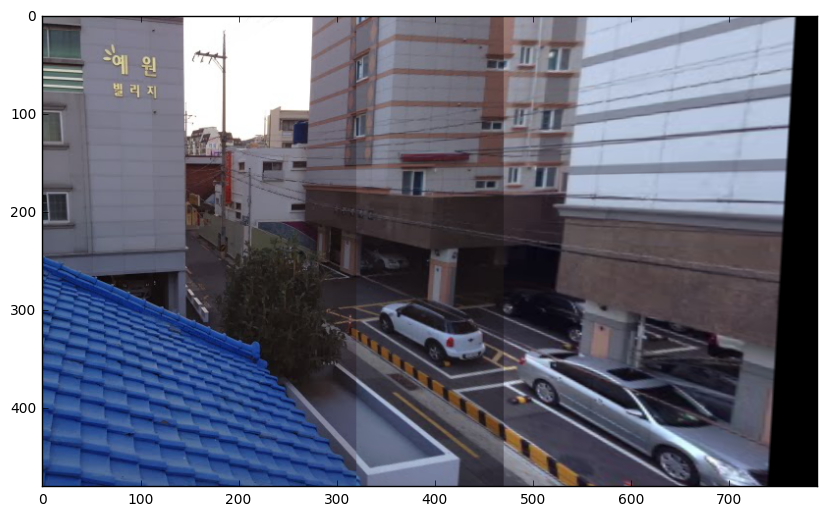

In [76]:
stitcher = Stitcher()
a=ans[:,0:470]
b=imgs[2]
ans2 = stitcher.stitch([a,b], reprojThresh=1.0, ratio=0.75)
plt.figure(figsize=(10,10))
plt.imshow(ans2);